In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import torch
import torchvision.transforms as transforms
from globsML.utils.eval import get_test_metrics
from globsML.utils.draw import plot_source
from globsML.utils.imageloader import load_data, CustomGCDataset
from globsML.utils.training import train_CNN as train
from globsML.utils.training import test_CNN as test
from globsML.models.CNN import CNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, trange

# list of thresholds used to calculate AUC ROC
thresh = np.arange(0,1.02,0.01)

### Load data

In [2]:
data_path = '../data/ACS_sources_original.csv'
data = pandas.read_csv(data_path)
galaxies_to_test = set(data[data['cluster'] == 'Fornax'].galaxy.unique())
    
available_galaxies = set(data['galaxy'].unique())
available_galaxies = available_galaxies.difference(set(list(galaxies_to_test)+['VCC538']))

In [3]:
images, labels, probabilities, galaxies, IDs = load_data(data, available_galaxies)
test_images, test_labels, test_probabilities, test_galaxies, test_IDs = load_data(data, galaxies_to_test)

### First: train a few other models to get an idea of achievable performance levels

In [115]:
knn = KNeighborsClassifier(1)
knn.fit(np.reshape(images, (len(images), 2*20*20)), labels)
pred = knn.predict(np.reshape(test_images, (len(test_images), 2*20*20)))
probs = knn.predict_proba(np.reshape(test_images, (len(test_images), 2*20*20)))[:,1]
stats_gal, stats_all, _, _, _, _, _ = get_test_metrics(list(galaxies_to_test), test_galaxies, test_IDs, test_labels, pred, probs=probs, thresh=thresh)

/home/dodo/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dodo/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [116]:
stats_gal.mean()

/tmp/ipykernel_264/1394020141.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_gal.mean()


TPR               0.767188
FDR               0.240065
FPR               0.038570
AUC(FDR,TPR)      0.744394
AUC(FPR,TPR)      0.864309
# found GCs     115.860465
# total GCs     143.279070
# fake GCs       15.116279
# sources       506.209302
dtype: float64

In [117]:
stats_all

,Galaxy,TPR,FDR,FPR,"AUC(FDR,TPR)","AUC(FPR,TPR)",# found GCs,# total GCs,# fake GCs,# sources
0,ALL,0.808635,0.115412,0.041651,0.82383,0.883492,4982,6161,650,21767


In [ ]:
knn = KNeighborsClassifier(12)
knn.fit(np.reshape(images, (len(images), 2*20*20)), labels)
pred = knn.predict(np.reshape(test_images, (len(test_images), 2*20*20)))
probs = knn.predict_proba(np.reshape(test_images, (len(test_images), 2*20*20)))[:,1]
stats_gal, stats_all, _, _, _, _, _ = get_test_metrics(list(galaxies_to_test), test_galaxies, test_IDs, test_labels, pred, probs=probs, thresh=thresh)

In [50]:
stats_gal.mean()

/tmp/ipykernel_536/1394020141.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_gal.mean()


TPR               0.753958
FDR               0.197299
FPR               0.028157
AUC(FDR,TPR)      0.834620
AUC(FPR,TPR)      0.955631
# found GCs     115.558140
# total GCs     143.279070
# fake GCs       11.069767
# sources       506.209302
dtype: float64

In [51]:
stats_all

,Galaxy,TPR,FDR,FPR,"AUC(FDR,TPR)","AUC(FPR,TPR)",# found GCs,# total GCs,# fake GCs,# sources
0,ALL,0.806525,0.08742,0.030501,0.914848,0.966198,4969,6161,476,21767


In [53]:
rforest = RandomForestClassifier(n_estimators = 200, random_state = 42424)
rforest.fit(np.reshape(images, (len(images), 2*20*20)), labels)
pred = rforest.predict(np.reshape(test_images, (len(test_images), 2*20*20)))
probs = rforest.predict_proba(np.reshape(test_images, (len(test_images), 2*20*20)))[:,1]
stats_gal, stats_all, _, _, _, _, _ = get_test_metrics(list(galaxies_to_test), test_galaxies, test_IDs, test_labels, pred, probs=probs, thresh=thresh)

/home/dodo/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dodo/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dodo/git/globsML/globsML/utils/eval.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  return auc(x,y)/(2*auc([0,x[-1]], [0,y[-1]])), x, y


In [54]:
stats_gal.mean()

/tmp/ipykernel_536/1394020141.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_gal.mean()


TPR               0.740933
FDR               0.177016
FPR               0.028347
AUC(FDR,TPR)           inf
AUC(FPR,TPR)      0.963042
# found GCs     115.930233
# total GCs     143.279070
# fake GCs       11.511628
# sources       506.209302
dtype: float64

In [55]:
stats_all

,Galaxy,TPR,FDR,FPR,"AUC(FDR,TPR)","AUC(FPR,TPR)",# found GCs,# total GCs,# fake GCs,# sources
0,ALL,0.809122,0.090328,0.031719,0.917892,0.972547,4985,6161,495,21767


### Create data loaders for use in pytorch

In [4]:
BATCHSIZE = 500
SEED = 1231423
EVAL_SIZE = 0.05
np.random.seed(SEED)
torch.manual_seed(SEED)

train_images, eval_images, train_labels, eval_labels = train_test_split(images, probabilities, test_size=EVAL_SIZE, random_state=SEED)
train_labels[train_labels<=0.2] = 0.
train_labels[train_labels>=0.8] = 1.
trainData = CustomGCDataset(train_images, train_labels, 
                        transforms.Compose([transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip()]))
train_loader = torch.utils.data.DataLoader(trainData, batch_size=BATCHSIZE, shuffle=True)

eval_labels = np.array(eval_labels>=0.5, dtype=int)
evalData = CustomGCDataset(eval_images, eval_labels)
eval_loader = torch.utils.data.DataLoader(evalData, batch_size=BATCHSIZE, shuffle=False)

testData = CustomGCDataset(test_images, test_labels)
test_loader = torch.utils.data.DataLoader(testData, batch_size=BATCHSIZE, shuffle=False)

### Create CNN model and optimizer

In [5]:
# create CNN
net = CNN()
net.cuda()

# set up optimiser
LR = 1e-3
REG = 1e-5
optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=REG)

### Train the CNN

Model parameters from the epoch with the best performance on validation data (highest TPR-FPR value) is used for testing later

In [8]:
training_losses = []
val_tpr = []
val_fdr = []
EPOCHS = 100

best_metric = 0
# training loop
for epoch in trange(EPOCHS):
    training_loss, mean_loss = train(net, 'cuda', train_loader, optimizer)
    tpr, fdr = test(net, 'cuda', eval_loader, eval_labels, epoch)
    training_losses += training_loss
    val_tpr.append(tpr)
    val_fdr.append(fdr)
    print('Epoch {} ---- TPR: {} -- FDR: {}'.format(epoch, tpr, fdr))
    if tpr-fdr > best_metric:
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'tpr': tpr,
            'fdr': fdr,
            }, 'Virgo2Fornax--CNN--best')
        best_metric = tpr-fdr
        print('NEW BEST')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

/home/dodo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 ---- TPR: 0.6908517350157729 -- FDR: 0.25
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 1 ---- TPR: 0.8722397476340694 -- FDR: 0.16966966966966968
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 2 ---- TPR: 0.8170347003154574 -- FDR: 0.10535405872193437
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 3 ---- TPR: 0.862776025236593 -- FDR: 0.08985024958402663
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 4 ---- TPR: 0.832807570977918 -- FDR: 0.05714285714285714
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 5 ---- TPR: 0.88801261829653 -- FDR: 0.08306188925081433
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 6 ---- TPR: 0.9211356466876972 -- FDR: 0.1191553544494721


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 7 ---- TPR: 0.8801261829652997 -- FDR: 0.07154742096505824
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 8 ---- TPR: 0.8690851735015773 -- FDR: 0.05163511187607573
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 9 ---- TPR: 0.9116719242902208 -- FDR: 0.07814992025518341
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 10 ---- TPR: 0.8706624605678234 -- FDR: 0.059625212947189095


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 11 ---- TPR: 0.917981072555205 -- FDR: 0.08201892744479496
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 12 ---- TPR: 0.886435331230284 -- FDR: 0.06020066889632107


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 13 ---- TPR: 0.8769716088328076 -- FDR: 0.0576271186440678


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 14 ---- TPR: 0.8722397476340694 -- FDR: 0.05792163543441227


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 15 ---- TPR: 0.8564668769716088 -- FDR: 0.05565217391304348


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 16 ---- TPR: 0.919558359621451 -- FDR: 0.08333333333333333
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 17 ---- TPR: 0.8738170347003155 -- FDR: 0.056218057921635436


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 18 ---- TPR: 0.861198738170347 -- FDR: 0.052083333333333336


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 19 ---- TPR: 0.919558359621451 -- FDR: 0.06570512820512821
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 20 ---- TPR: 0.9037854889589906 -- FDR: 0.05289256198347107


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 21 ---- TPR: 0.8548895899053628 -- FDR: 0.04409171075837742


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 22 ---- TPR: 0.8990536277602523 -- FDR: 0.05785123966942149


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 23 ---- TPR: 0.9022082018927445 -- FDR: 0.06688417618270799


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 24 ---- TPR: 0.8943217665615142 -- FDR: 0.045454545454545456


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 25 ---- TPR: 0.8943217665615142 -- FDR: 0.047058823529411764


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 26 ---- TPR: 0.9100946372239748 -- FDR: 0.06026058631921824


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 27 ---- TPR: 0.8722397476340694 -- FDR: 0.044905008635578586


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 28 ---- TPR: 0.8911671924290221 -- FDR: 0.05518394648829431


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 29 ---- TPR: 0.8643533123028391 -- FDR: 0.04861111111111111


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 30 ---- TPR: 0.916403785488959 -- FDR: 0.061389337641357025
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 31 ---- TPR: 0.9006309148264984 -- FDR: 0.06546644844517185


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 32 ---- TPR: 0.8517350157728707 -- FDR: 0.03398926654740608


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 33 ---- TPR: 0.9148264984227129 -- FDR: 0.06451612903225806


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 34 ---- TPR: 0.9100946372239748 -- FDR: 0.061788617886178863


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 35 ---- TPR: 0.889589905362776 -- FDR: 0.056856187290969896


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 36 ---- TPR: 0.9148264984227129 -- FDR: 0.07051282051282051


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 37 ---- TPR: 0.9006309148264984 -- FDR: 0.05930807248764415


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 38 ---- TPR: 0.9069400630914827 -- FDR: 0.054276315789473686


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 39 ---- TPR: 0.8848580441640379 -- FDR: 0.04753820033955857


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 40 ---- TPR: 0.9069400630914827 -- FDR: 0.05737704918032787


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 41 ---- TPR: 0.9085173501577287 -- FDR: 0.06493506493506493


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 42 ---- TPR: 0.9132492113564669 -- FDR: 0.06310679611650485


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 43 ---- TPR: 0.8943217665615142 -- FDR: 0.05970149253731343


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 44 ---- TPR: 0.8580441640378549 -- FDR: 0.038869257950530034


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 45 ---- TPR: 0.8832807570977917 -- FDR: 0.04923599320882852


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 46 ---- TPR: 0.8690851735015773 -- FDR: 0.04835924006908463


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 47 ---- TPR: 0.9227129337539433 -- FDR: 0.0625
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 48 ---- TPR: 0.88801261829653 -- FDR: 0.050590219224283306


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 49 ---- TPR: 0.88801261829653 -- FDR: 0.05218855218855219


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 50 ---- TPR: 0.88801261829653 -- FDR: 0.044142614601018676


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 51 ---- TPR: 0.9037854889589906 -- FDR: 0.059113300492610835


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 52 ---- TPR: 0.8943217665615142 -- FDR: 0.04384485666104553


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 53 ---- TPR: 0.8958990536277602 -- FDR: 0.05175292153589316


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 54 ---- TPR: 0.9258675078864353 -- FDR: 0.06677265500794913


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 55 ---- TPR: 0.8848580441640379 -- FDR: 0.04591836734693878


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 56 ---- TPR: 0.8801261829652997 -- FDR: 0.03460207612456748


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 57 ---- TPR: 0.8990536277602523 -- FDR: 0.0436241610738255


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 58 ---- TPR: 0.8769716088328076 -- FDR: 0.044673539518900345


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 59 ---- TPR: 0.8911671924290221 -- FDR: 0.047217537942664416


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 60 ---- TPR: 0.88801261829653 -- FDR: 0.047377326565143825


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 61 ---- TPR: 0.8927444794952681 -- FDR: 0.045531197301854974


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 62 ---- TPR: 0.8801261829652997 -- FDR: 0.039586919104991396


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 63 ---- TPR: 0.8990536277602523 -- FDR: 0.04201680672268908


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 64 ---- TPR: 0.8990536277602523 -- FDR: 0.04040404040404041


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 65 ---- TPR: 0.919558359621451 -- FDR: 0.05357142857142857
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 66 ---- TPR: 0.9022082018927445 -- FDR: 0.048252911813643926


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 67 ---- TPR: 0.9132492113564669 -- FDR: 0.05392156862745098


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 68 ---- TPR: 0.8832807570977917 -- FDR: 0.042735042735042736


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 69 ---- TPR: 0.8769716088328076 -- FDR: 0.04794520547945205


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 70 ---- TPR: 0.8785488958990536 -- FDR: 0.04130808950086059


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 71 ---- TPR: 0.9100946372239748 -- FDR: 0.052545155993431854


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 72 ---- TPR: 0.9227129337539433 -- FDR: 0.05339805825242718
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 73 ---- TPR: 0.9148264984227129 -- FDR: 0.046052631578947366


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 74 ---- TPR: 0.9037854889589906 -- FDR: 0.04817275747508306


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 75 ---- TPR: 0.8990536277602523 -- FDR: 0.05


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 76 ---- TPR: 0.9053627760252366 -- FDR: 0.04966887417218543


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 77 ---- TPR: 0.9116719242902208 -- FDR: 0.049342105263157895


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 78 ---- TPR: 0.88801261829653 -- FDR: 0.04088586030664395


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 79 ---- TPR: 0.8785488958990536 -- FDR: 0.04130808950086059


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 80 ---- TPR: 0.8958990536277602 -- FDR: 0.0453781512605042


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 81 ---- TPR: 0.8990536277602523 -- FDR: 0.0387858347386172


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 82 ---- TPR: 0.9116719242902208 -- FDR: 0.04304635761589404


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 83 ---- TPR: 0.917981072555205 -- FDR: 0.05672609400324149


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 84 ---- TPR: 0.88801261829653 -- FDR: 0.037606837606837605


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 85 ---- TPR: 0.8990536277602523 -- FDR: 0.04040404040404041


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 86 ---- TPR: 0.9022082018927445 -- FDR: 0.04187604690117253


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 87 ---- TPR: 0.9085173501577287 -- FDR: 0.051070840197693576


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 88 ---- TPR: 0.9116719242902208 -- FDR: 0.04462809917355372


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 89 ---- TPR: 0.8974763406940063 -- FDR: 0.043697478991596636


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 90 ---- TPR: 0.9337539432176656 -- FDR: 0.058823529411764705
NEW BEST


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 91 ---- TPR: 0.8958990536277602 -- FDR: 0.04215851602023609


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 92 ---- TPR: 0.889589905362776 -- FDR: 0.04081632653061224


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 93 ---- TPR: 0.9085173501577287 -- FDR: 0.04477611940298507


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 94 ---- TPR: 0.9037854889589906 -- FDR: 0.04340567612687813


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 95 ---- TPR: 0.8817034700315457 -- FDR: 0.03620689655172414


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 96 ---- TPR: 0.9053627760252366 -- FDR: 0.04809286898839138


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 97 ---- TPR: 0.9006309148264984 -- FDR: 0.040336134453781515


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 98 ---- TPR: 0.88801261829653 -- FDR: 0.04088586030664395


  0%|          | 0/119 [00:00<?, ?it/s]

Epoch 99 ---- TPR: 0.8832807570977917 -- FDR: 0.034482758620689655


### Load the model that performed best on validation data

In [7]:
loaded_net = CNN()
checkpoint = torch.load('Virgo2Fornax--CNN')
loaded_net.load_state_dict(checkpoint['model_state_dict'])
loaded_net.cuda()

<All keys matched successfully>

### Evaluate the model on the test data

In [11]:
loaded_net.train()
res = []

for i in tqdm(range(200)):
    pred = []
    for x,y in test_loader:
        xout, _ = loaded_net(x.cuda())
        xout = xout.flatten().cpu().detach().numpy()
        pred += list(xout)
    pred = np.array(pred)
    res.append(pred)

  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
nn = np.mean(res, axis=0)
nstd = np.max(res, axis=0)-np.min(res, axis=0)

In [14]:
stats_gal, stats_all, _, _, false_positives, false_negatives, found_GCs = get_test_metrics(list(galaxies_to_test), test_galaxies, test_IDs, test_labels, 1.*(nn>0.5), probs=nn, thresh=thresh)

/home/dodo/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dodo/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
stats_all

,Galaxy,TPR,FDR,FPR,"AUC(FDR,TPR)","AUC(FPR,TPR)",# found GCs,# total GCs,# fake GCs,# sources
0,ALL,0.936699,0.088885,0.036076,0.964096,0.989669,5771,6161,563,21767


In [16]:
stats_gal.mean()

/tmp/ipykernel_1039/1394020141.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_gal.mean()


TPR               0.898893
FDR               0.140138
FPR               0.031316
AUC(FDR,TPR)      0.924943
AUC(FPR,TPR)      0.988013
# found GCs     134.209302
# total GCs     143.279070
# fake GCs       13.093023
# sources       506.209302
dtype: float64

### Wrongly detected GCs

In [14]:
false_positives

{'FCC167': array([ 33,  81, 116, 121, 132, 182, 202, 204, 239, 274, 296, 356, 379,
        398, 402, 411, 515, 549, 558, 563, 566, 574, 593, 616, 650, 681,
        720, 769]),
 'FCC277': array([121, 158, 173, 183, 193, 219, 256, 288, 290, 293]),
 'FCC202': array([133, 167, 176, 192, 232, 269, 304, 349, 355, 562]),
 'FCC303': array([169, 226, 305, 307, 323]),
 'FCC301': array([ 90, 180, 214, 275]),
 'FCC90': array([177, 336]),
 'FCC170': array([ 82, 117, 120, 137, 149, 152, 153, 177, 178, 184, 185, 193, 199,
        201, 216, 219, 220, 224, 228, 229, 235, 240, 242, 243, 245, 254,
        295]),
 'FCC119': array([ 27,  95, 142, 157]),
 'FCC106': array([ 74, 140]),
 'FCC249': array([  6,   7,  29,  85, 170, 210, 241, 245, 325, 357, 362, 366, 436,
        437]),
 'FCC177': array([ 11, 147, 167, 168, 186, 214, 215, 223, 226, 229, 233, 238, 243,
        247, 254, 259, 260, 277, 278, 282, 290]),
 'FCC19': array([164, 174]),
 'FCC276': array([190, 200, 215, 238, 270, 365, 385, 420, 438, 453, 5

### GCs that were not found

In [15]:
false_negatives

{'FCC43': array([  8, 201, 245, 285, 306]),
 'FCC288': array([166, 169, 189]),
 'FCC119': array([ 13, 169, 225, 286]),
 'FCC303': array([], dtype=int64),
 'FCC19': array([37]),
 'FCC170': array([  4, 107, 113, 115, 284, 331]),
 'FCC182': array([ 60,  78, 158, 197, 232, 364]),
 'FCC63': array([ 59,  65, 117, 145, 318, 367, 376, 393, 431, 438, 442, 448, 485]),
 'IC2006': array([ 52, 225, 276, 282, 305, 375]),
 'FCC213': array([  27,   34,   45,   46,   56,   95,  128,  132,  138,  144,  161,
         163,  168,  187,  194,  202,  238,  247,  275,  294,  334,  350,
         351,  353,  472,  477,  559,  582,  606,  649,  670,  674,  680,
         709,  714,  754,  762,  770,  775,  780,  818,  846,  873,  892,
         906,  942,  989, 1075, 1147, 1157, 1187, 1194, 1209, 1251, 1259,
        1316, 1318, 1351, 1362, 1385]),
 'FCC184': array([ 63,  89, 113, 150, 185, 425, 441, 472, 557, 610]),
 'FCC277': array([ 12,  65, 151, 171, 209, 252, 294]),
 'FCC143': array([140, 153, 163, 182]),
 'FC

### An estimate for prediction uncertainty can be obtained using MC dropout

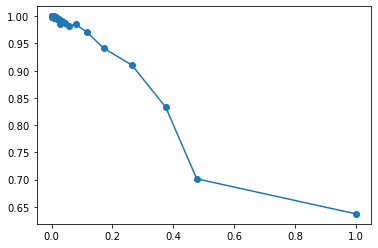

In [18]:
unc = []
for i in range(25):
    unc.append(np.percentile(nstd, i*4+4))
certainty = []
preds = []

for i in range(len(unc)-1):
    whichones = (nstd>unc[i])*(nstd<unc[i+1])
    lab = test_labels[whichones]
    pred = nn[whichones]>0.5
    certainty.append(np.mean(lab==pred))
    preds.append(nn[whichones])

plt.plot(unc[1:], certainty, marker = 'o')

### Replace the last layer of the trained CNN with a k nearest neighbour classifier

In [19]:
loaded_net.eval()

trainData = CustomGCDataset(train_images, train_labels)
train_loader = torch.utils.data.DataLoader(trainData, batch_size=BATCHSIZE, shuffle=False)

# map training data to latent space of CNN
new_train = []
for x,y in train_loader:
    _, xout = loaded_net(x.cuda())
    xout = xout.cpu().detach().numpy()
    new_train += list(xout)
    
# map test data to latent space of CNN
new_test = []
for x,y in test_loader:
    _, xout = loaded_net(x.cuda())
    xout = xout.cpu().detach().numpy()
    new_test += list(xout)

/home/dodo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [24]:
# train kNN on the latent training data
knn = KNeighborsClassifier(1)
knn.fit(new_train, np.array(train_labels >= 0.5, dtype=int))

# apply kNN on test latent representations for classification
pred = knn.predict(new_test)
probs = knn.predict_proba(new_test)[:,1]

# get evaluation metrics
stats_gal, stats_all, _, _, _, _, _ = get_test_metrics(list(galaxies_to_test), test_galaxies, test_IDs, test_labels, pred, probs=probs, thresh=thresh)

/home/dodo/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dodo/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
stats_gal.mean()

/tmp/ipykernel_371/1394020141.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_gal.mean()


TPR               0.874403
FDR               0.176939
FPR               0.036304
AUC(FDR,TPR)      0.832125
AUC(FPR,TPR)      0.919049
# found GCs     131.023256
# total GCs     143.279070
# fake GCs       14.720930
# sources       506.209302
dtype: float64

In [26]:
stats_all

,Galaxy,TPR,FDR,FPR,"AUC(FDR,TPR)","AUC(FPR,TPR)",# found GCs,# total GCs,# fake GCs,# sources
0,ALL,0.914462,0.101005,0.040561,0.886791,0.93695,5634,6161,633,21767


#### Repeat the same for higher number of neighbours k

In [23]:
knn = KNeighborsClassifier(12)
knn.fit(new_train, np.array(train_labels >= 0.5, dtype=int))
pred = knn.predict(new_test)
probs = knn.predict_proba(new_test)[:,1]
stats_gal, stats_all, _, _,false_positives, false_negatives, found_GCs = get_test_metrics(list(galaxies_to_test), test_galaxies, test_IDs, test_labels, pred, probs=probs, thresh=thresh)

/home/dodo/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dodo/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
stats_gal.mean()

/tmp/ipykernel_1039/1394020141.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_gal.mean()


TPR               0.894830
FDR               0.139822
FPR               0.029171
AUC(FDR,TPR)      0.913619
AUC(FPR,TPR)      0.977502
# found GCs     133.232558
# total GCs     143.279070
# fake GCs       12.023256
# sources       506.209302
dtype: float64

In [25]:
stats_all

,Galaxy,TPR,FDR,FPR,"AUC(FDR,TPR)","AUC(FPR,TPR)",# found GCs,# total GCs,# fake GCs,# sources
0,ALL,0.929882,0.082773,0.033128,0.95247,0.982568,5729,6161,517,21767


### Look at k nearest neighbours of a source that has not been correctly classified as a GC 

(here: source 71 of FCC47)

In [27]:
gid = np.where((test_galaxies=='FCC47')*(test_IDs==71))[0][0]

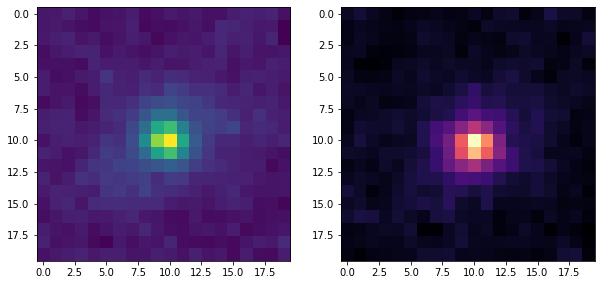

In [28]:
# look at the source
plot_source(test_images[gid])

In [29]:
# get neighbours
dist, sourc = knn.kneighbors(new_test[gid:gid+1])
dist = dist[0]
sourc = sourc[0]

#### Images and labels of the 12 nearest neighbours that were used to make the prediction

None
None
None
None
None
None
None
None
None
None
None
None


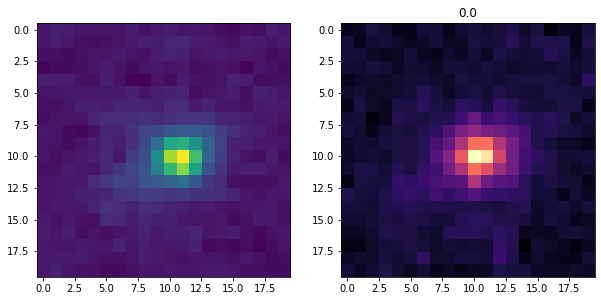

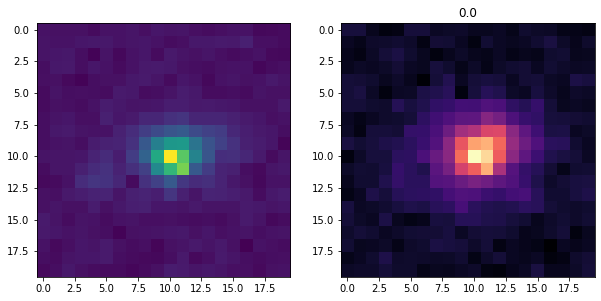

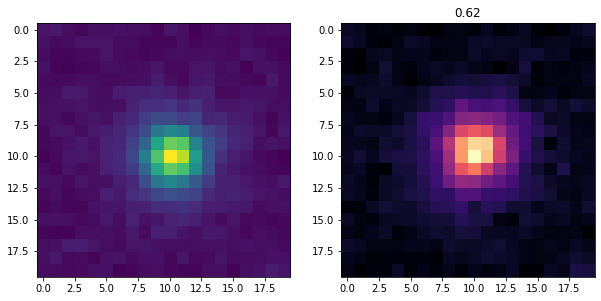

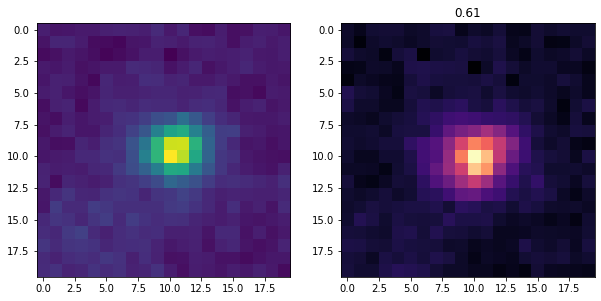

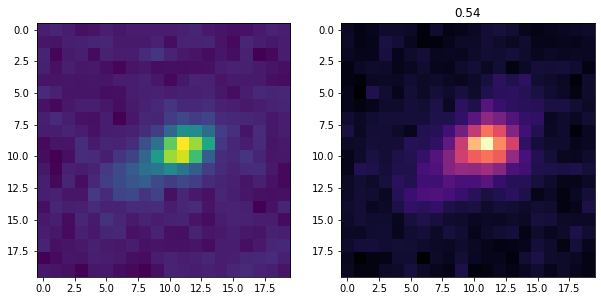

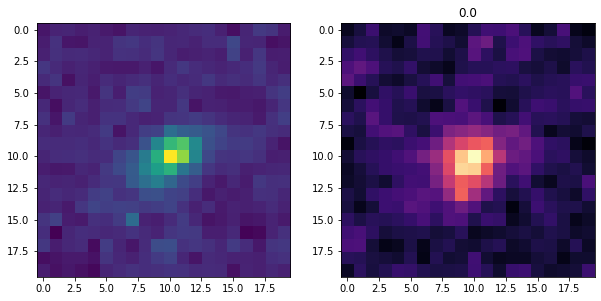

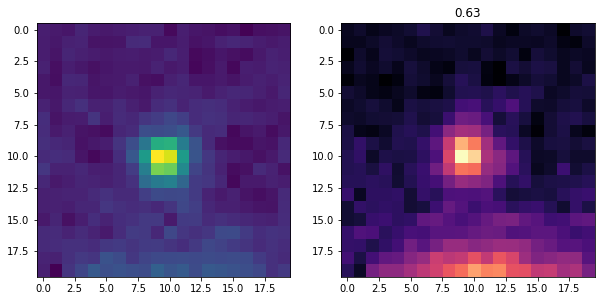

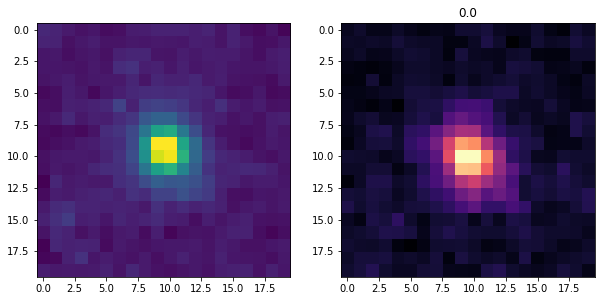

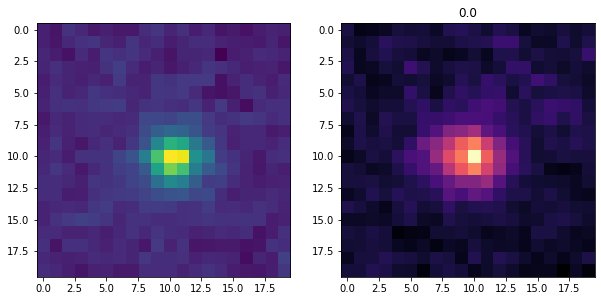

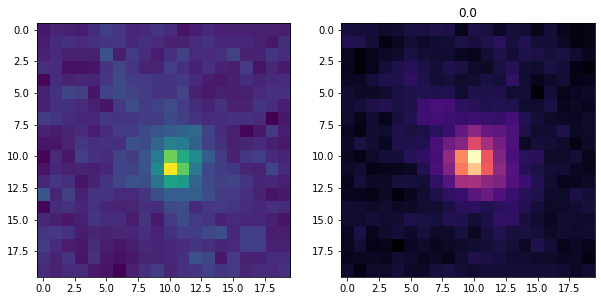

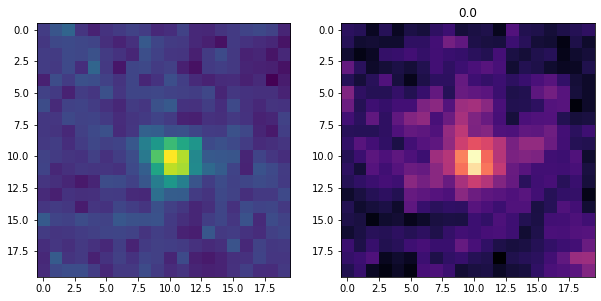

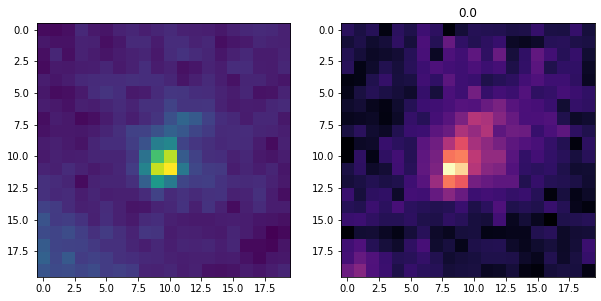

In [30]:
for i in range(12):
    print(plot_source(train_images[sourc[i]]))
    plt.title(train_labels[sourc[i]])

#### Distances in latent space to the 12 nearest neighbours

In [109]:
dist

array([0.44004756, 0.4464207 , 0.5065042 , 0.5187712 , 0.5217802 ,
       0.53846276, 0.5390488 , 0.5564105 , 0.5624113 , 0.5631143 ,
       0.5743289 , 0.58254635], dtype=float32)

### Same as above, but nicely plotted as in the paper

In [121]:
neighbors = np.load('FCC47--71--neighbors.npy')
fcc47 = np.load('FCC47--71.npy')
neighbor_labels = np.load('FCC47--71--neighbor_labels.npy')

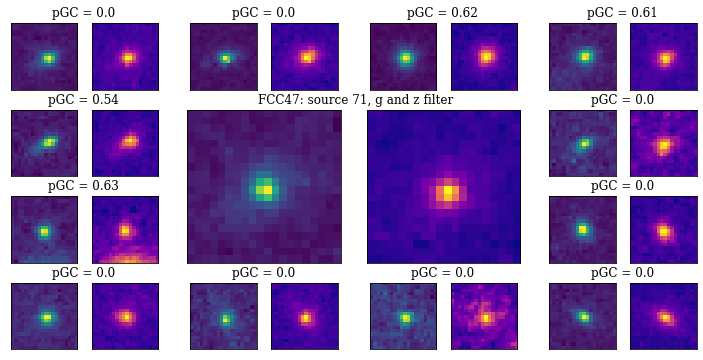

In [243]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib import rcParams

rcParams['font.family'] = 'serif'

n_rows = 4
n_cols = 4
off=0.1
left = 0.1
right = 0.9
msp = 0.05 # minor spacing
sp = 0.5  # major spacing
off=(1+msp)*(right-left)/(2*n_cols+n_rows*msp+(n_cols-1)*sp) # grid offset
wspace = sp+msp+1 #height space per grid
gso = GridSpec(n_rows, n_cols, left=left+off, right=right, wspace=wspace/4, hspace=0.3)#/7)
gse = GridSpec(n_rows, n_cols, left=left, right=right-off, wspace=wspace/4, hspace=0.3)
gsb = GridSpec(1, 2, left=0.32, top = 0.68, bottom = 0.325, right=0.68, wspace=0.14)
fig = plt.figure(figsize=[13,6])
axes_z = []
axes_g = []
for i in range(n_rows*n_cols):
    if i not in [5,6,9,10]:
        axes_z.append(fig.add_subplot(gso[i]))
        axes_g.append(fig.add_subplot(gse[i]))
ax470 = fig.add_subplot(gsb[0])
ax471 = fig.add_subplot(gsb[1])

for i in range(12):
    axes_g[i].imshow(neighbors[i][0])
    axes_z[i].imshow(neighbors[i][1], cmap = 'plasma')
    axes_z[i].set_yticks([])
    axes_g[i].set_yticks([])
    axes_g[i].set_title('pGC = {}'.format(neighbor_labels[i]), x = 1.1)
    axes_g[i].set_xticks([])
    axes_z[i].set_xticks([])

ax470.imshow(fcc47[0])
ax471.imshow(fcc47[1], cmap = 'plasma')
ax470.set_xticks([])
ax471.set_xticks([])
ax470.set_yticks([])
ax471.set_yticks([])

ax470.set_title('FCC47: source 71, g and z filter', x = 1.1)
fig.savefig('FCC47--explain_CNN.pdf')